# Personal Finance Exploratory Data Analysis

The goal of this notebook is to explore the data extracted from Reddit's Personal Finance subreddit, including information such as the title of the submissions, the date of submission, the flair (topic), etc. Using Natural Language Processing tools and data visualization, we aim to learn any obvious and underlying trends from the submission information. In particular, we want to observe whether the data can tell us any interesting details about the users who submitted the posts such as what financial issues they may be facing. 

In [89]:
# Begin by importing the relevant libraries and packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk import PorterStemmer
import string
import re
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pyLDAvis
import pyLDAvis.gensim 
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import spacy

In [40]:
# Import the data
df = pd.read_csv(r'C:\Users\joshu\Downloads\Data\reddit\reddit_pf1.csv', engine='python', index_col=[0])

In [3]:
# Top 10 most popular topics (flairs)
df.topic.value_counts()[0:10]

Debt          1256
Other         1205
Credit        1048
Investing      859
Retirement     824
Employment     724
Housing        709
unknown        654
Auto           560
Planning       526
Name: topic, dtype: int64

### Which are the most popular topics?

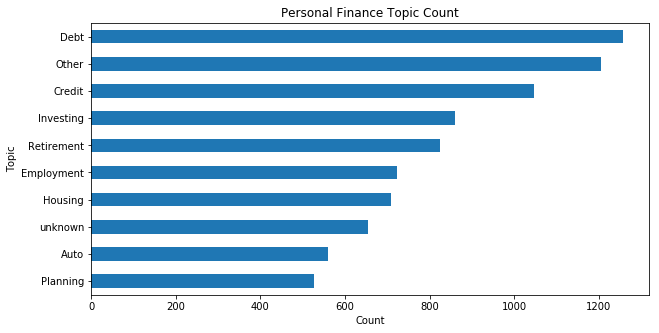

In [4]:
plt.figure(figsize = (10,5))
df.topic.value_counts()[0:10][::-1].plot(kind='barh')
plt.xlabel('Count')
plt.ylabel('Topic')
plt.title('Personal Finance Topic Count')
plt.show()

- Debt is the most popular topic in the personal finance subreddit, followed by Other and Credit. This indicates that debt is a major concern for many of the redditors (users) and they make submissions in order to seek advice.

- Other would include topics that don't match the default topics. With more data, it could be possible that Other is the most popular topic instead of Debt.

- Investment and Retirement are also similar in their counts while also being very similar in their functions.

- Let's look at the top 10 most popular submissions by sorting them by the number of upvotes.

In [5]:
# Top 10 most popular headlines
[title for title in df.sort_values(by='upvotes', ascending=False)['title'].values[:10]]

["IRS will allow employers to match their employees' student loan repayments",
 'Your amazon store card is probably scamming you',
 'So I fell for a scam yesterday and it still angers me.',
 'Wife passed away. I would truly appreciate some help figuring out where I stand.',
 'Bought a car today. Transmission went out 60 miles from the car lot and everyone had gone home for the day. Is there any chance I can get a refund?',
 'My girlfriend is being offered a too good to be true job with little to no personal history with employer.',
 'Do I need a credit card? I have been strongly advised against it by my parents who say its a scam and should be illegal but everything I look at says that no credit is just as bad if not worse than low credit. What should I do?',
 '[US] Paypal account balance is -$2000. What can they do?',
 'Why You Might Consider A Trade Over College (One Real-World Perspective)',
 '"Hidden" costs of buying a home and how to prepare for them.']

- There are a variety of different subjects in the top 10 most popular posts, ranging from scams to dealing with the loss of a family member.

- However, 3 of the top 10 include the word "scam", showing that this may be a popular subject in /r/personalfinance and could happen often. This could be a common issue among many people living in the US.

- While some posts are seeking advice, others provide advice such as '"Hidden" costs of buying a home and how to prepare for them.'

- Next let's tokenize the submission titles and drop stopwords to extract key words from the 20 most popular submissions. 

- **Tokenization**

Tokenization is essentially the process of segmenting a text into pieces, such as words, phrases, symbols, etc. 

Let's create a list of the tokens for each submission title.

In [70]:
import spacy
nlp = spacy.load('en_core_web_sm')

def create_tokens(text):
    doc = nlp(text)
    tokens = [token.text for token in doc]
    return tokens

df['tokenized_title'] = df['clean_title'].apply(lambda x: create_tokens(x.lower()))

In [72]:
# Create a pandas series of the tokens by count
all_words = pd.Series(np.concatenate(df['tokenized_title'])).value_counts()

In [90]:
# Add 'k' to the list of stopwords since it seems to occur often
stopwords = stopwords.words('english')
stopwords.append('k')
stopwords = set(stopwords)

In [93]:
all_words = all_words[[word not in stopwords for word in all_words.index]]
all_words = all_words[[word not in string.punctuation for word in all_words.index]]
all_words = all_words[[word not in string.digits for word in all_words.index]]
all_words = all_words[["'" not in word for word in all_words.index]]

In [95]:
all_words[:10].index

Index(['credit', 'car', 'debt', 'need', 'card', 'money', 'loan', 'help',
       'advice', 'pay'],
      dtype='object')

### Which are the most popular tokens?

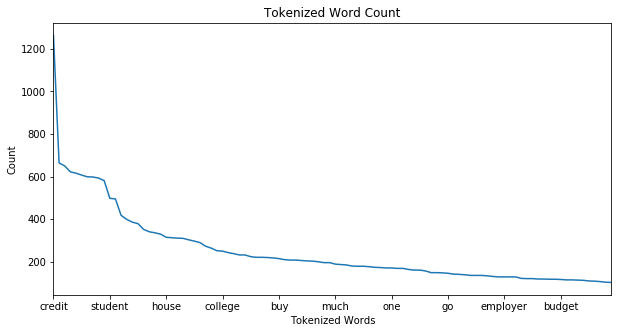

In [96]:
# Create a list of words evenly spread out by 10 in the top 100.
x = np.arange(0,100,10)
ten_words_list = []
for a in x:
    ten_words_list.append(all_words.index[a])

# Plot the words.
plt.figure(figsize = (10,5))
all_words[:100].plot()
plt.xticks(np.arange(0,100, 10), ten_words_list)
plt.xlabel('Tokenized Words')
plt.ylabel('Count')
plt.title('Tokenized Word Count')
plt.show()

### How does the popularity of posts change over time?

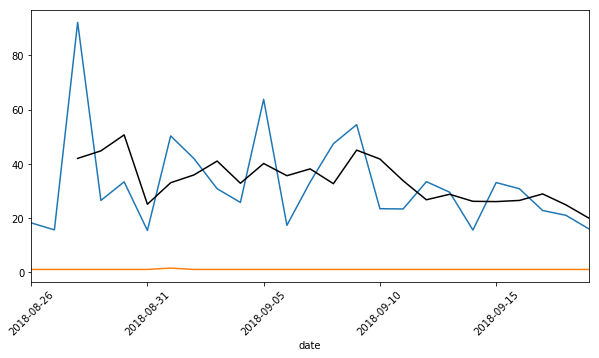

In [97]:
plt.figure(figsize=(10,5))
df.groupby('date')['upvotes'].mean().plot()
df.groupby('date')['upvotes'].median().plot()
df.groupby('date')['upvotes'].mean().rolling(window=3).mean().plot(color='black')
plt.xticks(rotation=45)
plt.show()

### What does the distribution of the title length look like?

In [98]:
# Create new column for text length
df['text_len'] = df['title'].apply(lambda x: len(x) - x.count(' '))
# Filter out the anomalies 
df = df[(df['topic'] != 'THIS IS A SPAMMER') & (df['topic'] != 'Meta')]

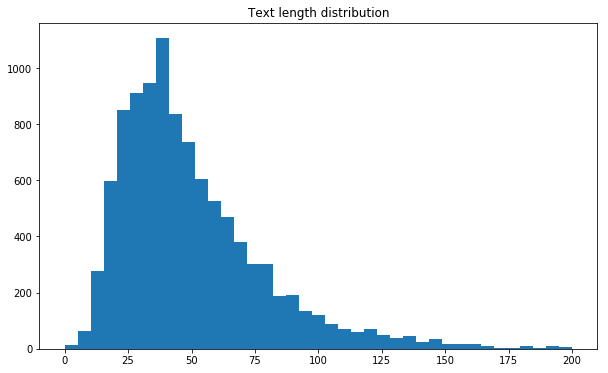

In [99]:
bins = np.linspace(0,200,40)
plt.figure(figsize=(10,6))
plt.hist(df['text_len'], bins)
plt.title('Text length distribution')
plt.show()

- Next, let's observe the distribution of the title lengths according to topic.

In [100]:
unique_topics = [x for x in df['topic'].unique() if x == x]

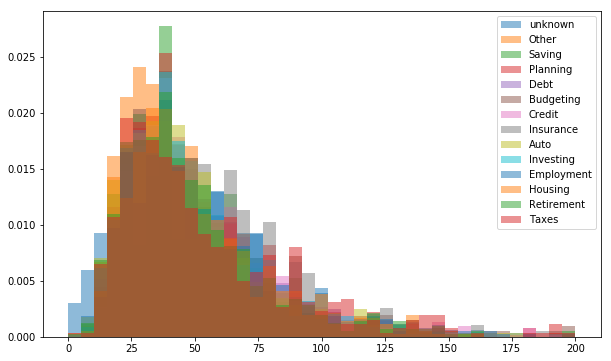

In [101]:
bins = np.linspace(0,200,40)

plt.figure(figsize=(10,6))
for topic in unique_topics:
    plt.hist(df[df['topic']==topic]['text_len'], bins, alpha = 0.5, density = True, label = topic)
plt.legend()
plt.show()

### Most popular tokens by POS (Part-of-Speech) Tagging

In [20]:
# Load the dictionary
nlp = spacy.load('en_core_web_sm')
doc = nlp(u'Apple is looking at buying U.K. startup for $1 billion')

for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
          token.shape_, token.is_alpha, token.is_stop)

Apple apple PROPN NNP nsubj Xxxxx True False
is be VERB VBZ aux xx True True
looking look VERB VBG ROOT xxxx True False
at at ADP IN prep xx True True
buying buy VERB VBG pcomp xxxx True False
U.K. u.k. PROPN NNP compound X.X. False False
startup startup NOUN NN dobj xxxx True False
for for ADP IN prep xxx True True
$ $ SYM $ quantmod $ False False
1 1 NUM CD compound d False False
billion billion NUM CD pobj xxxx True False


In [167]:
def create_tokens(text):
    doc = nlp(text)
    tokens = [token for token in doc]
    return tokens
df['tokenized_title1'] = df['clean_title'].apply(lambda x: create_tokens(x.lower()))

In [180]:
def pos_tag(token_list):
    pos_list = [x.tag_ for x in token_list]
    return pos_list

df['pos_tag'] = df['tokenized_title1'].apply(lambda x: pos_tag(x))

In [210]:
def topicify(df):
    tags = df['pos_tag']
    tokens = df['tokenized_title1']
    return [token.text for (tag, token) in zip(tags, tokens) if tag in ['NN', 'NNS']]

In [211]:
df['gen_topics'] = df.apply(topicify, axis = 'columns')

In [212]:
df['gen_topics'].head()

0           [ways, side, money]
1    [year, update, job, month]
2                            []
3            [savings, account]
4    [tools, incomes, expenses]
Name: gen_topics, dtype: object

In [213]:
topic_counts = pd.Series(np.concatenate(df['gen_topics'].values)).value_counts()

In [214]:
topic_counts.head()

credit    1251
car        663
debt       646
card       615
money      607
dtype: int64

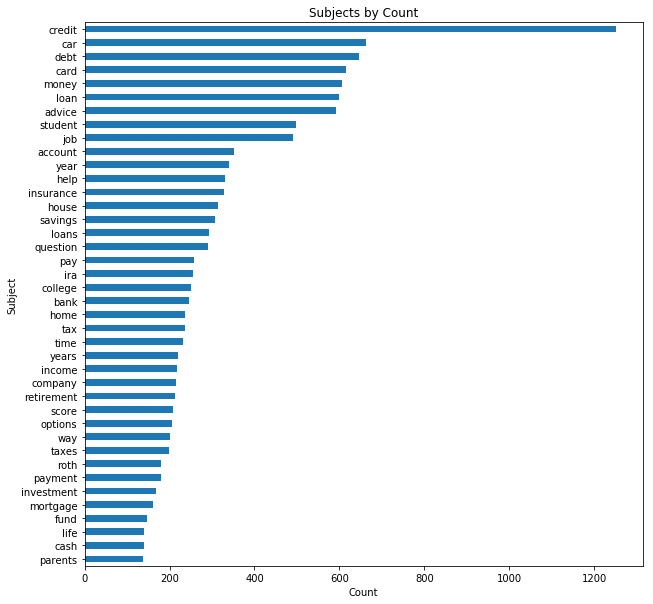

In [221]:
plt.figure(figsize=(10,10))
topic_counts.head(40)[::-1].plot(kind='barh')
plt.xlabel('Count')
plt.ylabel('Subject')
plt.title('Subjects by Count')
plt.show()